# Fake-Real News Detection

Darya Misiulia

### Project legend

- Introduction and Data Description
- Missing Values
- Explorary Data Analysis
- Text Pre-processing
- Multinomial Naive Bayes Model
- LSTM
- Bidirectional LSTM
- Conclusions
- Sources

## Introduction

Fake news is the inclusion of information that leads people astray. Fake news is currently spreading like water and people are sharing this information without verifying it. This is often done to promote or impose certain ideas, and is often achieved through political programs.

In this project I am going to try to determine if the news is real or face. Dataset has around 10,000 piece of news article scraped from **Politifact** (https://www.politifact.com/) website.

## Data Description

The dataset is having 6 attributes among which **News_Headline** is the most important to us in order to classify news as FALSE or TRUE.

**News_Headline** - contains piece of information that has to be analysed.

**Link_Of_News** - contains url of News Headlines specified in very first column.

**Source** - this column contains author names who has posted the information on facebook, instagram, twitter or any other social-
media platform.

**Stated_On** - this column contains date when the information is posted by the authors on different social-media platforms.

**Date** - This column contains date when this piece of information is analysed by politifact team of fact-checkers in order to labelize as FAKE or REAL.

**Label** - This column contains 5 class labels : True, Mostly-True, Half-True, Barely-True, False, Pants on Fire.

The **Label** has 6 classes in project I will use this dataset for binary classification(TRUE/FALSE). 

<p>

First of all, I load to memory all necessary packages.

In [4]:
#Importing Libraries

import unidecode #Unidecode()remove accented characters from text
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re #remove whitespaces
import time
import nltk
import warnings
import string
import timeit
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from autocorrect import Speller #Spell checker
from bs4 import BeautifulSoup
from collections import Counter
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split

lemmatizer = nltk.stem.WordNetLemmatizer()
tokens = nltk.tokenize.WhitespaceTokenizer()  

warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Xiaomi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [61]:
import tensorflow as tf
print(tf.__version__)

2.6.0


The dataset was taken from publicly available source Kaggle. Which can be found under following link: https://www.kaggle.com/techykajal/fakereal-news

I gonna import the csv file into the notebook.

In [127]:
#Read Dataset
date_df = pd.read_csv('tm_data.csv', encoding = 'latin-1')
print('Number of Data points : ', date_df.shape[0])
print('Number of features :', date_df.shape[1])
print('features :', date_df.columns.values)


Number of Data points :  9960
Number of features : 6
features : ['News_Headline' 'Link_Of_News' 'Source' 'Stated_On' 'Date' 'Label']


In [128]:
#head of dataset
date_df.head()

,News_Headline,Link_Of_News,Source,Stated_On,Date,Label
0,Says Osama bin Laden endorsed Joe Biden,https://www.politifact.com/factchecks/2020/jun...,Donald Trump Jr.,"June 18, 2020","June 19, 2020",FALSE
1,CNN aired a video of a toddler running away fr...,https://www.politifact.com/factchecks/2020/jun...,Donald Trump,"June 18, 2020","June 19, 2020",pants-fire
2,Says Tim Tebow kneeled in protest of abortion...,https://www.politifact.com/factchecks/2020/jun...,Facebook posts,"June 12, 2020","June 19, 2020",FALSE
3,Even so-called moderate Democrats like Joe Bi...,https://www.politifact.com/factchecks/2020/jun...,Paul Junge,"June 10, 2020","June 19, 2020",barely-true
4,"""Our health department, our city and our count...",https://www.politifact.com/factchecks/2020/jun...,Jeanette Kowalik,"June 14, 2020","June 18, 2020",TRUE


Let's look of the type of data.

In [129]:
date_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9960 entries, 0 to 9959
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   News_Headline  9960 non-null   object
 1   Link_Of_News   9960 non-null   object
 2   Source         9960 non-null   object
 3   Stated_On      9960 non-null   object
 4   Date           9960 non-null   object
 5   Label          9960 non-null   object
dtypes: object(6)
memory usage: 467.0+ KB


The structer of dataset.

In [130]:
date_df.shape

(9960, 6)

<p>

## Missing Values

Cheking missing values in each column.

In [131]:
#Searching for null values

date_df.isna().sum()

News_Headline    0
Link_Of_News     0
Source           0
Stated_On        0
Date             0
Label            0
dtype: int64

So data doesn't contain missing values.

<p>

## Explorary Data Analysis

Let's check how is look **Label** column.

In [132]:
print(date_df.groupby("Label").size())

Label
FALSE          2273
TRUE           1036
barely-true    1737
full-flop        70
half-flip        27
half-true      1685
mostly-true    1722
no-flip           8
pants-fire     1402
dtype: int64


It can be seen that there are several unknown categories, the news of which could not be assigned to one of the 6 categories. Since there is little data in the categories, I decided to delete them.

In [133]:
#Delite no-flip,half-flip and full-flop categorize
date_df = date_df[date_df['Label'] != 'no-flip']
date_df = date_df[date_df['Label'] != 'full-flop']
date_df = date_df[date_df['Label'] != 'half-flip']

print(date_df.groupby("Label").size())

Label
FALSE          2273
TRUE           1036
barely-true    1737
half-true      1685
mostly-true    1722
pants-fire     1402
dtype: int64


Now let's see on distribution of **Labels**.

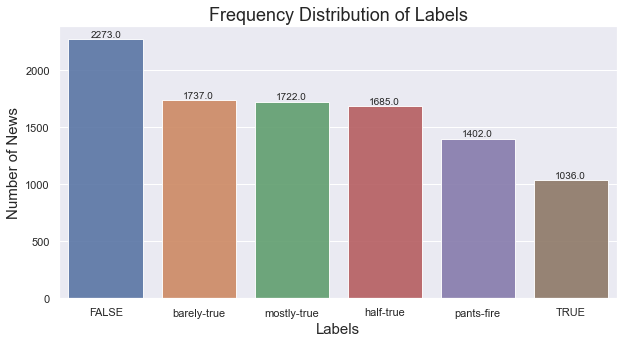

In [134]:
%matplotlib inline
count = date_df["Label"].value_counts()
sns.set(style="darkgrid")
plt.figure(figsize=(10,5))
plots = sns.barplot(count.index, count.values, alpha=0.9)
for bar in plots.patches: 
    plots.annotate(bar.get_height(),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=10, xytext=(0, 5),
                   textcoords='offset points')
plt.title('Frequency Distribution of Labels', fontsize = 18)
plt.ylabel('Number of News', fontsize = 15)
plt.xlabel('Labels', fontsize = 15)
plt.show()

Also I plot top of news sources.

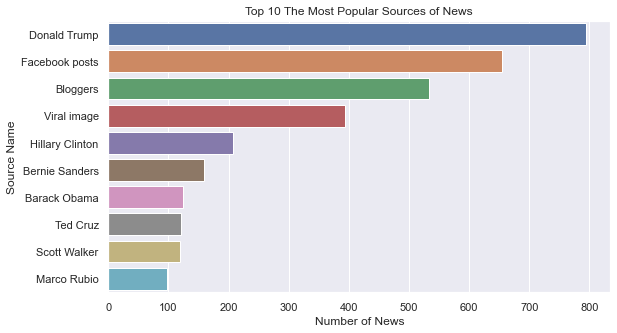

In [135]:
####Most popular Sources########
athlete_order = date_df["Source"].value_counts().head(10).index
plt.figure(figsize=(9, 5))
sns.countplot(data=date_df, y='Source', order=athlete_order)
plt.title('Top 10 The Most Popular Sources of News')
plt.xlabel('Number of News')
plt.ylabel('Source Name');
plt.show()

The most popular sources - Donald Trump and Facebook posts.

<p>

Since in project I will be using binary classification we convert class Labels into **FALSE** or **TRUE**.

In [136]:
###Changing classification###

date_df.Label[date_df.Label == 'mostly-true'] = 'TRUE'
date_df.Label[date_df.Label == 'barely-true'] = 'TRUE'
date_df.Label[date_df.Label == 'half-true'] = 'TRUE'
date_df.Label[date_df.Label == 'pants-fire'] = 'FALSE'

date_df.head()

,News_Headline,Link_Of_News,Source,Stated_On,Date,Label
0,Says Osama bin Laden endorsed Joe Biden,https://www.politifact.com/factchecks/2020/jun...,Donald Trump Jr.,"June 18, 2020","June 19, 2020",FALSE
1,CNN aired a video of a toddler running away fr...,https://www.politifact.com/factchecks/2020/jun...,Donald Trump,"June 18, 2020","June 19, 2020",FALSE
2,Says Tim Tebow kneeled in protest of abortion...,https://www.politifact.com/factchecks/2020/jun...,Facebook posts,"June 12, 2020","June 19, 2020",FALSE
3,Even so-called moderate Democrats like Joe Bi...,https://www.politifact.com/factchecks/2020/jun...,Paul Junge,"June 10, 2020","June 19, 2020",TRUE
4,"""Our health department, our city and our count...",https://www.politifact.com/factchecks/2020/jun...,Jeanette Kowalik,"June 14, 2020","June 18, 2020",TRUE


In [137]:
print(date_df.groupby("Label").size())

Label
FALSE    3675
TRUE     6180
dtype: int64


Converting categorical data **"Label"** to binary data.

In [138]:
df_one = pd.get_dummies(date_df["Label"])
 
df_two = pd.concat((df_one, date_df), axis=1)
df_two = df_two.drop(["Label"], axis=1)
 
#False = 0 and True = 1 
df_two = df_two.drop(["FALSE"], axis=1)
 
#rename the Column
date_df = df_two.rename(columns={"TRUE": "Label"})
 
#print the Result
date_df.head()

,Label,News_Headline,Link_Of_News,Source,Stated_On,Date
0,0,Says Osama bin Laden endorsed Joe Biden,https://www.politifact.com/factchecks/2020/jun...,Donald Trump Jr.,"June 18, 2020","June 19, 2020"
1,0,CNN aired a video of a toddler running away fr...,https://www.politifact.com/factchecks/2020/jun...,Donald Trump,"June 18, 2020","June 19, 2020"
2,0,Says Tim Tebow kneeled in protest of abortion...,https://www.politifact.com/factchecks/2020/jun...,Facebook posts,"June 12, 2020","June 19, 2020"
3,1,Even so-called moderate Democrats like Joe Bi...,https://www.politifact.com/factchecks/2020/jun...,Paul Junge,"June 10, 2020","June 19, 2020"
4,1,"""Our health department, our city and our count...",https://www.politifact.com/factchecks/2020/jun...,Jeanette Kowalik,"June 14, 2020","June 18, 2020"


## Text Pre-processing

Befor start modeling I should clean data.

First of all I create a function which removing new newlines and tabs and replacing all **\n,\\n,\t,\\** with a space.

In [139]:
def remove_NewlinesTabs(text):    
    format_text = text.replace('\\n', ' ').replace('\n', ' ').replace('\t',' ').replace('\\', ' ').replace('. com', '.com')
    return format_text

Here creating function which removing extra **WhiteSpaces** and replace extra whitespaces to one whitespace.

In [140]:
def remove_WhiteSpace(text):
    wo = re.compile(r'\s+')
    wo_whitespace = re.sub(wo, ' ', text)
    text = wo_whitespace.replace('?', ' ? ').replace(')', ') ') #bc are some instances where no space after '?' and ')'
    return text                                                   #was decided to replace them with one space 
                                                               #so that two words do not count as one token  

In this function we strip html tags via **BeautifulSoup**.

In [141]:
def remove_HtmlTags(text):
    #BeautifulSoup initiating to object soup
    soup = BeautifulSoup(text, "html.parser")
    
    #Get text without html tags
    new_text = soup.get_text(separator=" ")
    return new_text

That function remove links at the text.

In [142]:
def remove_Links(text):
    #Removing all links that starts with https
    wo_https = re.sub(r'http\S+', '', text)
    
    #Removing all text that ends with .com
    wo_link = re.sub(r"\ [A-Za-z]*\.com", " ", wo_https)
    return wo_link

Function which remove accented characters -> replace accented characters from text to **ASCII characters**.

In [143]:
def remove_AccentCharact(text):
    text = unidecode.unidecode(text)
    return text

Here creating function which convert text to lower case using function **lower()**.

In [144]:
def lower_Casing(text):
    text = text.lower()
    return text

That function remove special characters.

In [145]:
def remove_SpecialCharacter(text):
    text = re.sub('\[[^]]*\]', ' ', text)
    text = re.sub('[^a-zA-Z]',' ',text)
    return text

Function which extand contraction words. For this I also create dictionary of contraction words. Then in function I tokenizing text into tokens. Checking if word exist in dictionary with contraction words if yes than replace that word with the key value.At the end convert from list of tokens to string.

In [146]:
CONTRACTION_WORDS = {
"ain't": "is not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"who've": "who have",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you would",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have",
}

def extend_ContractionWord(text, contraction_words =  CONTRACTION_WORDS):
    #text into tokens
    tokens = text.split(' ')
    
    for word in tokens: 
         if word in CONTRACTION_WORDS: 
                tokens = [t.replace(word, CONTRACTION_WORDS[word]) for t in tokens]
                
    #from list of tokens to string
    text = ' '.join(str(w) for w in tokens) 
    return text    

Here using function **stopwords** I create fuction which remove stopwords from text.

In [147]:
stop_words = set(stopwords.words('english'))

def remove_StopWords(text):
    #clear text
    wo_stop_words = [word for word in word_tokenize(text) if word.lower() not in stop_words]

    #convert list of tokens to string
    text = ' '.join(wo_stop_words)    
    return text

Function which checking for spellings in English language and then correct spelling.

In [148]:
def correct_Spelling(text):
    #checking for spellings in English language
    spelling = Speller(lang='en')
    text = spelling(text)
    return text

And last function it is function for **Lemmatization**. Firstly convert words to the root form and then convert list of tokens to string.

In [149]:
lemmatizer = nltk.stem.WordNetLemmatizer()
tokens = nltk.tokenize.WhitespaceTokenizer()

def lemmatization(text):
    #words to the root form
    lemm_text = [lemmatizer.lemmatize(w) for w in tokens.tokenize(text)]    
    #list of tokens to string
    text = ' '.join(lemm_text) 
    return text

Function to merge all previos functions.

In [150]:
def text_preproces(text, remove_accentcharact=True, extend_contractionword=True, lemmatiz = True,
                       remove_whitespace=True, remove_newlinestabs=True,
                       lower_casing=True,correct_spelling=True,
                       remove_htmltags=True, remove_links=True, remove_specialcharacter=True,
                       remove_stopwords=True):
  
    if remove_newlinestabs == True: 
        Data = remove_NewlinesTabs(text)

    if remove_htmltags == True:
        Data = remove_HtmlTags(Data)

    if remove_links == True:
        Data = remove_Links(Data)

    if remove_accentcharact == True: 
        Data = remove_AccentCharact(Data)

    if lower_casing == True:
        Data = lower_Casing(Data)

    if extend_contractionword == True:
        Data = extend_ContractionWord(Data)

    if remove_specialcharacter == True:
        Data = remove_SpecialCharacter(Data)

    stop_words = set(stopwords.words('english'))   
    if remove_stopwords == True: 
        Data = remove_StopWords(Data)

   
    spelling = Speller(lang='en')
    if correct_spelling == True: 
        Data = correct_Spelling(Data)
    
    #Converts words to lemma form
    lemmatizer = nltk.stem.WordNetLemmatizer()
    tokens = nltk.tokenize.WhitespaceTokenizer()  
    if lemmatiz == True: 
        Data = lemmatization(Data)
        
    if remove_whitespace == True:
        Data = remove_WhiteSpace(Data)
       
    return Data

Creating new column with clear data - **New_Headline**.

In [151]:
list_news = date_df['News_Headline'].to_list()

final_news = []
full = []

for a in list_news:
    processed_news = text_preproces(a) #Cleaned text of Content attribute after pre-processing
    final_news.append(processed_news)
full.extend(final_news)

date_df['New_Headline'] = full

Now let's look to new column.

In [152]:
date_df['New_Headline']

0                  say obama bin laden endorsed joe biden
1       cnn aired video toddler running away another t...
2       say tim below needed protest abortion national...
3       even called moderate democrat like joe biden e...
4       health department city county declared racism ...
                              ...                        
9955    say obama administration plan reduce number be...
9956    foreign intelligence surveillance court transp...
9957    past four year u senate passed nine appropriat...
9958    immigration reform marco rubio along saying bo...
9959    since newton people died end gun lost afghanistan
Name: New_Headline, Length: 9855, dtype: object

In [153]:
date_df.head()

,Label,News_Headline,Link_Of_News,Source,Stated_On,Date,New_Headline
0,0,Says Osama bin Laden endorsed Joe Biden,https://www.politifact.com/factchecks/2020/jun...,Donald Trump Jr.,"June 18, 2020","June 19, 2020",say obama bin laden endorsed joe biden
1,0,CNN aired a video of a toddler running away fr...,https://www.politifact.com/factchecks/2020/jun...,Donald Trump,"June 18, 2020","June 19, 2020",cnn aired video toddler running away another t...
2,0,Says Tim Tebow kneeled in protest of abortion...,https://www.politifact.com/factchecks/2020/jun...,Facebook posts,"June 12, 2020","June 19, 2020",say tim below needed protest abortion national...
3,1,Even so-called moderate Democrats like Joe Bi...,https://www.politifact.com/factchecks/2020/jun...,Paul Junge,"June 10, 2020","June 19, 2020",even called moderate democrat like joe biden e...
4,1,"""Our health department, our city and our count...",https://www.politifact.com/factchecks/2020/jun...,Jeanette Kowalik,"June 14, 2020","June 18, 2020",health department city county declared racism ...


**Description of text information**

In [154]:
all_words = [word for tokens in date_df['New_Headline'] for word in tokens]
sentence_lengths = [len(tokens) for tokens in date_df['New_Headline']]

VOCAB = sorted(list(set(all_words)))

print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))
print("Max sentence length is %s" % max(sentence_lengths))

725385 words total, with a vocabulary size of 27
Max sentence length is 293


**TOP 20 WORDS**

In [155]:
pd.Series(' '.join(date_df['New_Headline']).split()).value_counts().head(20)

say          2768
state        1106
year         1045
percent       846
trump         799
people        774
tax           697
president     634
million       569
u             539
american      493
one           482
obama         468
said          457
country       451
time          443
would         417
new           415
donald        390
clinton       380
dtype: int64

**WordCloud for News**

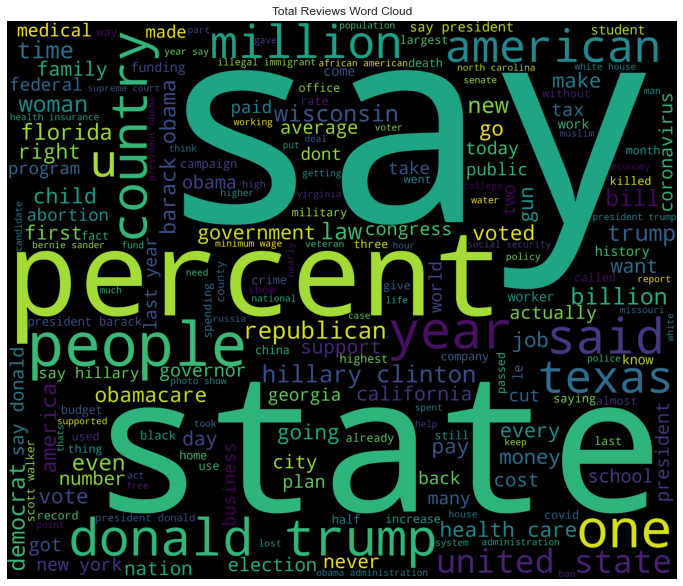

In [35]:
words = ' '.join(date_df['New_Headline'])

wordcloud = WordCloud(
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(words)
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Total Reviews Word Cloud')
plt.show()

**TOP 10 words for TRUE and FALSE labels**

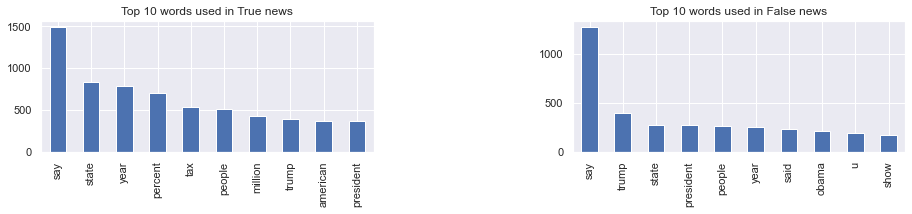

In [36]:
tr = date_df[date_df['Label']=='TRUE']
fls = date_df[date_df['Label']=='FALSE']

plt.subplot(3, 2, 1)
t = pd.Series(' '.join(tr['New_Headline']).split())
t.value_counts()[:10].plot.bar() 
plt.title("Top 10 words used in True news")

plt.subplot(3, 2, 2)
f = pd.Series(' '.join(fls['New_Headline']).split())
f.value_counts()[:10].plot.bar() 
plt.title("Top 10 words used in False news")

plt.subplots_adjust(top=2, bottom=0, left=0, right=2, hspace=0.7, wspace=0.6)
plt.show()

<p>

## Multinomial Naive Bayes Model

**Divide dataset into training and testing sample**

Spliting variables into a training and test set.

In [37]:
x_train_nb, x_test_nb, y_train_nb, y_test_nb = train_test_split(date_df, date_df.Label, test_size=0.25, random_state=0)

print(x_train_nb.shape, y_train_nb.shape, x_test_nb.shape, y_test_nb.shape)

(7391, 7) (7391,) (2464, 7) (2464,)


**Vectorization**

Now vectorize out test and train data using **CountVectorizer()**.

In [38]:
vectorizer = CountVectorizer()

x_train_nb = vectorizer.fit_transform(x_train_nb['New_Headline'])
x_test_nb = vectorizer.transform(x_test_nb['New_Headline'])

Building the Multinominal Naive Bayes model.

In [202]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.naive_bayes import MultinomialNB

NB = MultinomialNB()
NB.fit(x_train_nb,y_train_nb)

MultinomialNB()

**Prediction**

In [203]:
NB_pred = NB.predict(x_test_nb)

**Accuracy score and F1 score**

In [204]:
ac_mn = accuracy_score(y_test_nb, NB_pred)
f1 = f1_score(y_test_nb, NB_pred, pos_label='TRUE')

print("Accuracy of the model is equal to:",ac_mn.round(3))
print('The F1 score is {:.3f}.\n'.format(f1))

Accuracy of the model is equal to: 0.706
The F1 score is 0.779.



**Confusion Matrix**

Confusion Matrix


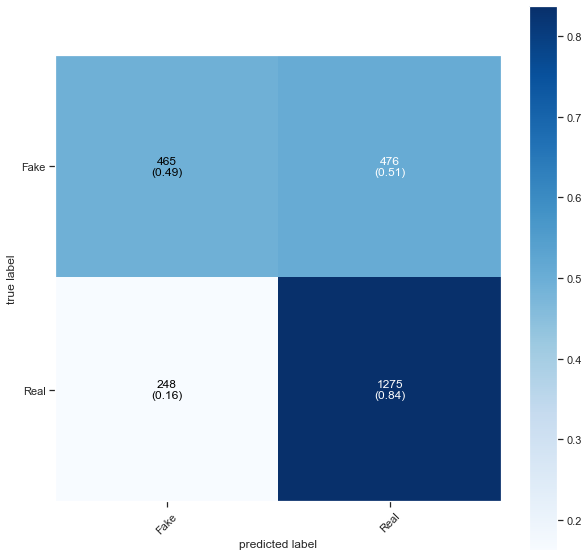

In [40]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

print("Confusion Matrix")
CR = confusion_matrix(y_test_nb, NB_pred)

fig, ax = plot_confusion_matrix(CR,figsize=(10, 10),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True,
                               class_names=['Fake', 'Real'])
plt.show()

**Classification report**

In [41]:
from sklearn.metrics import classification_report

print("Classification report")
print(classification_report(y_test_nb, NB_pred))

Classification report
              precision    recall  f1-score   support

       FALSE       0.65      0.49      0.56       941
        TRUE       0.73      0.84      0.78      1523

    accuracy                           0.71      2464
   macro avg       0.69      0.67      0.67      2464
weighted avg       0.70      0.71      0.70      2464



<p>

## WOrd2VEC

Words2Vec is one of the the most popular techniques for learning word embedding using a shallow neural network.

The word embedding is the most popular way to represent the vocabulary of a document. It is able to capture the context of a word in a document, semantic and syntactic similarity, relationship to other words, etc.

First of all let's load libraries.

In [42]:
import gensim
from gensim.models import Word2Vec
import keras
from keras.preprocessing.text import Tokenizer
import numpy as np

I was creating 2 new variables. First one **l** include data about Labels(1 for True, and 0 for False), and second one **text** with news headline.

In [156]:
l = date_df['Label'].values

text = [w.split() for w in date_df['New_Headline'].tolist()]

In [157]:
type(text)

list

In next step creating Word Vectors by **Word2Vec** method.

In [158]:
#Dimension of vectors we are generating
DIM = 200

w2v_model = gensim.models.Word2Vec(sentences = text,
                                    vector_size = DIM,
                                  window = 10,
                                  min_count = 1)

In [159]:
#vocab size
len(w2v_model.wv.key_to_index)

9654

Now having represented each of 9654 words by a 200dim vector.

Lets checkout these vectors.

In [160]:
w2v_model.wv.key_to_index

{'say': 0,
 'state': 1,
 'year': 2,
 'percent': 3,
 'trump': 4,
 'people': 5,
 'tax': 6,
 'president': 7,
 'million': 8,
 'u': 9,
 'american': 10,
 'one': 11,
 'obama': 12,
 'said': 13,
 'country': 14,
 'time': 15,
 'would': 16,
 'new': 17,
 'donald': 18,
 'clinton': 19,
 'job': 20,
 'bill': 21,
 'every': 22,
 'health': 23,
 'law': 24,
 'school': 25,
 'republican': 26,
 'billion': 27,
 'united': 28,
 'texas': 29,
 'since': 30,
 'rate': 31,
 'care': 32,
 'hillary': 33,
 'last': 34,
 'get': 35,
 'voted': 36,
 'wisconsin': 37,
 'woman': 38,
 'gun': 39,
 'show': 40,
 'city': 41,
 'medical': 42,
 'first': 43,
 'democrat': 44,
 'cut': 45,
 'even': 46,
 'government': 47,
 'right': 48,
 'child': 49,
 'money': 50,
 'florida': 51,
 'obamacare': 52,
 'pay': 53,
 'america': 54,
 'federal': 55,
 'two': 56,
 'vote': 57,
 'house': 58,
 'illegal': 59,
 'barack': 60,
 'day': 61,
 'want': 62,
 'nation': 63,
 'go': 64,
 'going': 65,
 'number': 66,
 'family': 67,
 'border': 68,
 'make': 69,
 'dollar': 70,

Also we can see similar words for word from data.

In [161]:
w2v_model.wv.most_similar('china')

[('water', 0.999924898147583),
 ('use', 0.9999198913574219),
 ('case', 0.9999159574508667),
 ('found', 0.9999157190322876),
 ('back', 0.999914288520813),
 ('covid', 0.9999131560325623),
 ('home', 0.999908447265625),
 ('part', 0.999908447265625),
 ('car', 0.9999070167541504),
 ('life', 0.9999041557312012)]

In [162]:
w2v_model.wv.most_similar('trump')

[('president', 0.99773108959198),
 ('obama', 0.9967207312583923),
 ('say', 0.9957536458969116),
 ('said', 0.9950141906738281),
 ('impeachment', 0.9935949444770813),
 ('elect', 0.9934890866279602),
 ('melanie', 0.9931319952011108),
 ('former', 0.9929168820381165),
 ('bin', 0.9927230477333069),
 ('impeach', 0.9926881194114685)]

Cannot pass string words to embedding layer, thus need some way to represent each words by numbers.

Tokenizer can represent each word by number.

I used **Tokenizer()** function.

In [163]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(text)

In [164]:
text = tokenizer.texts_to_sequences(text)

Checking how much words in each news headline.

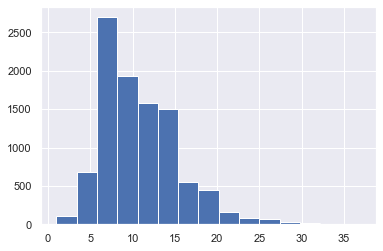

In [165]:
plt.hist([len(t) for t in text], bins = 15)
plt.show()

As we can see on histogram for number of words in news shows that most news headlines are under 20 words.

<p>

**Padding embedded news**

Let's keep all news to 20, add padding to news with less than 20 words and truncating long ones.

In [166]:
max_len = 20

#Padding the sentences
text = pad_sequences(text, padding = 'pre', maxlen = max_len)

print(text)

[[   0    0    0 ...  787  159  229]
 [   0  676 3723 ...  815   37    5]
 [   0    0    0 ... 3724 1200   11]
 ...
 [   0    0    0 ...  653 4431   22]
 [   0    0    0 ...   84   36  183]
 [   0    0    0 ...   40  176 1066]]


We can see all the sentences are of equal length with the addition of zeros in front of the sentences and making all the sentences of length 20.

In [195]:
#adding 1 because of reserved 0 index

v_size = len(tokenizer.word_index) + 1
vocab = tokenizer.word_index

Function to create weight matrix from **Word2Vec** model.

In [168]:
def weight_matrix(m):
    weight_mx = np.zeros((v_size, DIM))
    
    for w, i in vocab.items():
        weight_mx[i] = m.wv[w]
    return weight_mx

Obtaining embedding vectors from **Word2Vec** and using them as weights of the unlearned keras embedding layer.

In [169]:
embed_vec = weight_matrix(w2v_model)

In [170]:
embed_vec.shape

(9655, 200)

<p>

## LSTM

Loading libraries.

In [171]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

**Creating the LSTM model**

In [172]:
embedding_vector_features = 40

lstm_m = Sequential()
#Non-trainable embeddidng layer
lstm_m.add(Embedding(v_size, embedding_vector_features, input_length = max_len))
lstm_m.add(Dropout(0.3))
lstm_m.add(LSTM(100)) #Adding 100 lstm neurons in the layer
lstm_m.add(Dropout(0.3))
lstm_m.add(Dense(1, activation='sigmoid'))

lstm_m.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(lstm_m.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 20, 40)            386200    
_________________________________________________________________
dropout_2 (Dropout)          (None, 20, 40)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               56400     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 442,701
Trainable params: 442,701
Non-trainable params: 0
_________________________________________________________________
None


**Train test splitting**

In [173]:
X_final=np.array(text)
y_final=np.array(l)

In [174]:
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.3, random_state = 42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6898, 20), (2957, 20), (6898,), (2957,))

Fitting with 10 epochs and 32 batch size.

In [175]:
lstm_m.fit(X_train, y_train, validation_data=(X_test,y_test),epochs = 10, batch_size=32)

Epoch 1/10
216/216 [==============================] - 6s 18ms/step - loss: 0.6330 - accuracy: 0.6518 - val_loss: 0.5795 - val_accuracy: 0.7031
Epoch 2/10
216/216 [==============================] - 3s 15ms/step - loss: 0.4967 - accuracy: 0.7685 - val_loss: 0.6047 - val_accuracy: 0.6990
Epoch 3/10
216/216 [==============================] - 3s 16ms/step - loss: 0.3877 - accuracy: 0.8305 - val_loss: 0.7024 - val_accuracy: 0.6804
Epoch 4/10
216/216 [==============================] - 3s 16ms/step - loss: 0.2947 - accuracy: 0.8803 - val_loss: 0.7209 - val_accuracy: 0.6730
Epoch 5/10
216/216 [==============================] - 4s 18ms/step - loss: 0.2267 - accuracy: 0.9124 - val_loss: 0.7911 - val_accuracy: 0.6720
Epoch 6/10
216/216 [==============================] - 4s 19ms/step - loss: 0.1669 - accuracy: 0.9384 - val_loss: 0.9358 - val_accuracy: 0.6781
Epoch 7/10
216/216 [==============================] - 4s 19ms/step - loss: 0.1273 - accuracy: 0.9524 - val_loss: 1.1996 - val_accuracy: 0.6554

**Prediction**

In [180]:
lstm_pred = (lstm_m.predict(X_test) > 0.5).astype("int32")

**Accuracy of the model**

In [199]:
acc_lstm = accuracy_score(y_test,lstm_pred)

print("Accuracy of the LSTM model is equal to:",acc_lstm)

Accuracy of the LSTM model is equal to: 0.6614812309773419


**Confusion Matrix**

Confusion Matrix


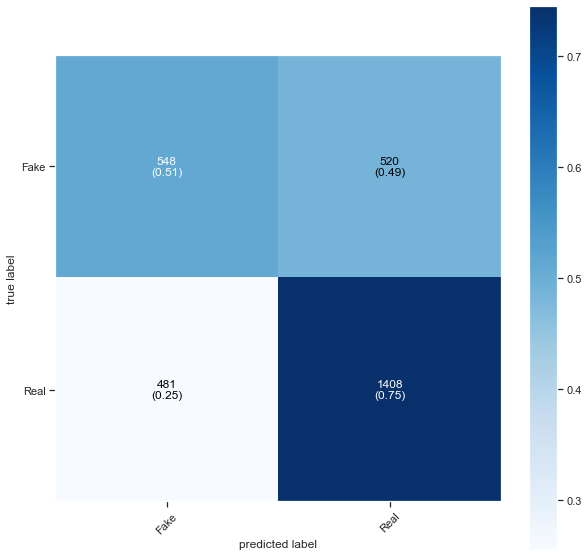

In [182]:
print("Confusion Matrix")
CR = confusion_matrix(y_test, lstm_pred)

fig, ax = plot_confusion_matrix(CR,figsize=(10, 10),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True,
                               class_names=['Fake', 'Real'])
plt.show()

**Classification report**

In [183]:
# Creating classification report 
print("Classification report")
print(classification_report(y_test, lstm_pred))

Classification report
              precision    recall  f1-score   support

           0       0.53      0.51      0.52      1068
           1       0.73      0.75      0.74      1889

    accuracy                           0.66      2957
   macro avg       0.63      0.63      0.63      2957
weighted avg       0.66      0.66      0.66      2957



## Bidirectional LSTM

**Creating the Bi-LSTM model**

In [185]:
# Creating bidirectional lstm model
embedding_vector_features = 40

lstm_bi=Sequential()
lstm_bi.add(Embedding(v_size, embedding_vector_features, input_length = max_len))
lstm_bi.add(Bidirectional(LSTM(100))) # Bidirectional LSTM layer
lstm_bi.add(Dropout(0.3))
lstm_bi.add(Dense(1,activation='sigmoid'))
lstm_bi.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(lstm_bi.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 20, 40)            386200    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200)               112800    
_________________________________________________________________
dropout_5 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 201       
Total params: 499,201
Trainable params: 499,201
Non-trainable params: 0
_________________________________________________________________
None


Fitting with 10 epochs and 32 batch size.

In [196]:
lstm_bi.fit(X_train, y_train, validation_data=(X_test,y_test),epochs = 10, batch_size=32)

Epoch 1/10
216/216 [==============================] - 5s 24ms/step - loss: 0.0093 - accuracy: 0.9974 - val_loss: 2.9774 - val_accuracy: 0.6578
Epoch 2/10
216/216 [==============================] - 5s 24ms/step - loss: 0.0457 - accuracy: 0.9839 - val_loss: 1.9520 - val_accuracy: 0.6486
Epoch 3/10
216/216 [==============================] - 6s 27ms/step - loss: 0.0253 - accuracy: 0.9899 - val_loss: 2.2117 - val_accuracy: 0.6459
Epoch 4/10
216/216 [==============================] - 6s 26ms/step - loss: 0.0227 - accuracy: 0.9922 - val_loss: 2.1469 - val_accuracy: 0.6520
Epoch 5/10
216/216 [==============================] - 6s 26ms/step - loss: 0.0101 - accuracy: 0.9970 - val_loss: 2.4532 - val_accuracy: 0.6480
Epoch 6/10
216/216 [==============================] - 6s 26ms/step - loss: 0.0086 - accuracy: 0.9978 - val_loss: 2.5021 - val_accuracy: 0.6557
Epoch 7/10
216/216 [==============================] - 6s 28ms/step - loss: 0.0034 - accuracy: 0.9991 - val_loss: 2.8201 - val_accuracy: 0.6429

**Prediction**

In [192]:
lstm_bi_pred = (lstm_bi.predict(X_test) > 0.5).astype("int32")

**Accuracy score**

In [198]:
acc_bi = accuracy_score(y_test,lstm_bi_pred)

print("Accuracy of the LSTM model is equal to:",acc_bi)

Accuracy of the LSTM model is equal to: 0.6520121745011837


**Confusion matrix**

Confusion Matrix


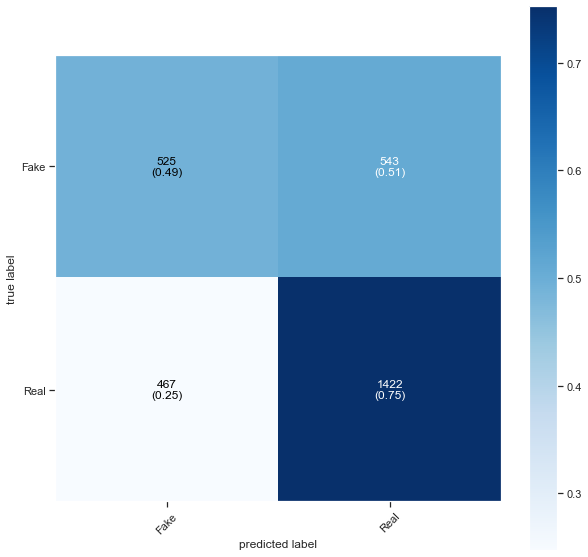

In [189]:
print("Confusion Matrix")
CR = confusion_matrix(y_test, lstm_bi_pred)

fig, ax = plot_confusion_matrix(CR,figsize=(10, 10),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True,
                               class_names=['Fake', 'Real'])
plt.show()

**Classification report**

In [190]:
print("Classification report")
print(classification_report(y_test, lstm_bi_pred))

Classification report
              precision    recall  f1-score   support

           0       0.53      0.49      0.51      1068
           1       0.72      0.75      0.74      1889

    accuracy                           0.66      2957
   macro avg       0.63      0.62      0.62      2957
weighted avg       0.65      0.66      0.66      2957



## Summary and Conclution

In [206]:
# make a dictionary with all the results
res = {
           'Multinomial Naive Bayes Model': ac_mn,
           'LSTM model': acc_lstm,
           'Bi-LSTM model': acc_bi,       
          }

res_df = pd.DataFrame.from_dict(res, orient='index', 
                                           columns=['Accuracy'])
res_df

,Accuracy
Multinomial Naive Bayes Model,0.706169
LSTM model,0.661481
Bi-LSTM model,0.652012


Looking at **accuracy score** and comparing each other I can say that the best model is Multinomial Naive Bayes Model so it has the highest value.

<p>

## Sources

https://www.kaggle.com/techykajal/fakereal-news
https://data-flair.training/blogs/advanced-python-project-detecting-fake-news/
https://www.kaggle.com/chelseabrk/fake-news-detection-detailed-explanations/notebook
https://www.analyticsvidhya.com/blog/2021/07/detecting-fake-news-with-natural-language-processing/#h2_2
https://towardsdatascience.com/how-i-created-a-fake-news-detector-with-python-65b1234123c4
https://www.hindawi.com/journals/complexity/2021/5557784/
https://www.hindawi.com/journals/complexity/2020/8885861/#materials-and-methods
https://www.kaggle.com/mitramir5/nlp-visualization-eda-glove#Prediction-with-RidgeClassifier,-NaiveBayes,-LinearSVM